In [6]:
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import yfinance as yf
import pandas as pd
import numpy as np

assets = ["NFLX"]
start_date = "2010-01-01"
end_date = "2023-11-30"

data = yf.download(assets, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


# Explore

In [7]:
data.shape

(3501, 6)

In [8]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.931429,7.961429,7.565714,7.640000,7.640000,17239600
2010-01-05,7.652857,7.657143,7.258571,7.358571,7.358571,23753100
2010-01-06,7.361429,7.672857,7.197143,7.617143,7.617143,23290400
2010-01-07,7.731429,7.757143,7.462857,7.485714,7.485714,9955400
2010-01-08,7.498571,7.742857,7.465714,7.614286,7.614286,8180900


# Preprocessing

In [9]:
data = data.ffill()
data_normalized = (data - data.min()) / (data.max() - data.min())
train_data = data_normalized

In [10]:
train_data.shape

(3501, 6)

In [11]:
train_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,0.001417,0.001128,0.000934,0.000908,0.000908,0.051195
2010-01-05,0.001011,0.000690,0.000482,0.000497,0.000497,0.071912
2010-01-06,0.000586,0.000712,0.000391,0.000874,0.000874,0.070441
2010-01-07,0.001126,0.000834,0.000782,0.000682,0.000682,0.028026
2010-01-08,0.000786,0.000813,0.000787,0.000870,0.000870,0.022382


In [45]:
def create_model(latent_dims=16,loss="mean_squared_error",optimizer="adam",input_dim=6):
    model = keras.Sequential(
        [
            keras.layers.InputLayer(input_shape=(input_dim,)),
            
            # encoder
            keras.layers.Dense(128, activation="relu"),
            keras.layers.Dense(64, activation="relu"),
            keras.layers.Dense(32, activation="relu"),
            
            # latent space
            keras.layers.Dense(latent_dims, activation="relu"),
            
            # decoder
            keras.layers.Dense(32, activation="relu"),
            keras.layers.Dense(64, activation="relu"),
            keras.layers.Dense(128, activation="relu"),
            keras.layers.Dense(input_dim, activation="tanh"),
        ]
    )
    model.compile(optimizer=optimizer, loss=loss)
    return model

In [46]:
model = create_model()

In [47]:
epochs = 100
batch_size = 32

model.fit(train_data, train_data, epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/100
110/110 [==============================] - 2s 2ms/step - loss: 0.0146
Epoch 2/100
110/110 [==============================] - 0s 2ms/step - loss: 3.2506e-04
Epoch 3/100
110/110 [==============================] - 0s 2ms/step - loss: 1.5023e-04
Epoch 4/100
110/110 [==============================] - 0s 2ms/step - loss: 9.9902e-05
Epoch 5/100
110/110 [==============================] - 0s 2ms/step - loss: 7.1887e-05
Epoch 6/100
110/110 [==============================] - 0s 2ms/step - loss: 6.0277e-05
Epoch 7/100
110/110 [==============================] - 0s 2ms/step - loss: 5.3204e-05
Epoch 8/100
110/110 [==============================] - 0s 2ms/step - loss: 4.2722e-05
Epoch 9/100
110/110 [==============================] - 0s 2ms/step - loss: 3.4498e-05
Epoch 10/100
110/110 [==============================] - 0s 2ms/step - loss: 3.2541e-05
Epoch 11/100
110/110 [==============================] - 0s 2ms/step - loss: 2.5809e-05
Epoch 12/100
110/110 [==============================] - 

In [48]:
def evaluate(model, train_data):
    reconstructed_data = model.predict(train_data)
    reconstruction_errors = np.mean(np.square(reconstructed_data - train_data), axis=1)

    threshold = np.mean(reconstruction_errors) + 2 * np.std(reconstruction_errors)

    fig, ax = plt.subplots(figsize=(10, 6))

    plt.plot(reconstruction_errors)
    ax.axhline(y=threshold, color="red", linestyle="--", label="Threshold")
    plt.xlabel("Time")
    plt.ylabel("Reconstruction Error")
    plt.title("Anomaly Detection with Threshold")
    plt.legend()

110/110 [==============================] - 0s 1ms/step


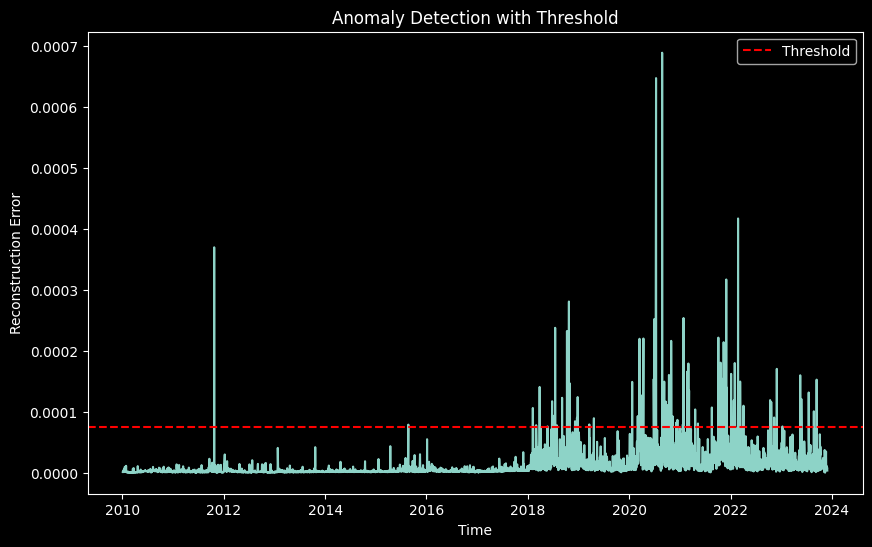

In [49]:
evaluate(model, train_data)

# Variational Autoencoder

In [50]:
def encoder(latent_dims=16,input=keras.layers.Input(shape=(6,))):
    x = keras.layers.Dense(64, activation="relu")(input)
    x = keras.layers.Dense(32, activation="relu")(x)
    mu = keras.layers.Dense(latent_dims, name="latent_mu")(x)
    sigma = keras.layers.Dense(latent_dims, name="latent_sigma")(x)
    return mu, sigma


def reparameterize(mean, log_var):
    std = tf.exp(mean * 0.5)
    eps = tf.random.normal(tf.shape(log_var))
    return mean + eps * std


def decoder(latent_inputs,input_dims=6):
    x = keras.layers.Dense(32, activation="relu")(latent_inputs)
    x = keras.layers.Dense(64, activation="relu")(x)
    outputs = keras.layers.Dense(input_dims, activation="tanh")(x)
    return outputs

In [51]:
def create_model(input_dim=6,latent_dims=16,loss="mean_squared_error",optimizer="adam"):
    input = keras.layers.Input(shape=(input_dim,))
    mu, sigma = encoder(input=input,latent_dims=latent_dims)
    latent = reparameterize(mu, sigma)
    decoded = decoder(latent_inputs=latent,input_dims=input_dim)
    model = keras.Model(inputs=input, outputs=decoded)

    model.compile(optimizer=optimizer, loss=loss)

    return model


In [52]:
vae = create_model()

In [53]:
vae.fit(train_data, train_data, epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/100
110/110 [==============================] - 1s 3ms/step - loss: 0.0628
Epoch 2/100
110/110 [==============================] - 0s 2ms/step - loss: 0.0073
Epoch 3/100
110/110 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 4/100
110/110 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 5/100
110/110 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 6/100
110/110 [==============================] - 0s 2ms/step - loss: 8.1048e-04
Epoch 7/100
110/110 [==============================] - 0s 2ms/step - loss: 6.2980e-04
Epoch 8/100
110/110 [==============================] - 0s 2ms/step - loss: 4.7582e-04
Epoch 9/100
110/110 [==============================] - 0s 2ms/step - loss: 3.8603e-04
Epoch 10/100
110/110 [==============================] - 0s 2ms/step - loss: 3.3016e-04
Epoch 11/100
110/110 [==============================] - 0s 2ms/step - loss: 2.8495e-04
Epoch 12/100
110/110 [==============================] - 0s 2ms/step - lo

110/110 [==============================] - 0s 1ms/step


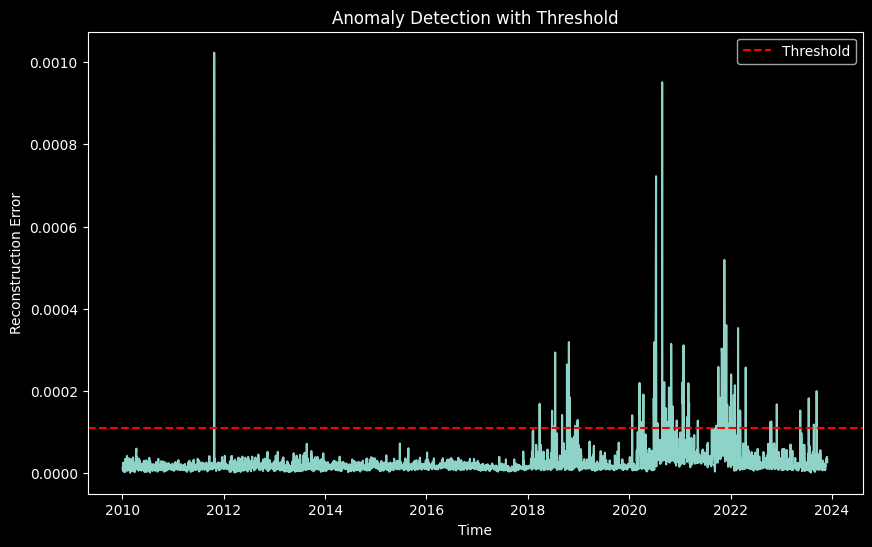

In [54]:
evaluate(vae, train_data)